In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import halfnorm
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_CDDM(ub, lb, delta, mu_alpha, sigma_alpha, sigma_z, ndt=0, sp=0, sigma=1, dt=0.001):
    x = sp
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
    
    alpha = -np.abs(np.random.normal(mu_alpha, sigma_alpha))
    
    return (rt+ndt)*ch, alpha, np.random.normal(alpha + ndt, sigma_z)

In [3]:
def f(x, t, z, tau, delta, sigma=1):
    term1 = 1/np.sqrt(2 * np.pi * sigma**2 * (t-tau))
    term2 = -(x - z - delta * (t-tau))**2 / (2 * sigma**2 * (t-tau))
    return term1 * np.exp(term2)

def psi(b, db, t, z, tau, delta, sigma=1):
    term1 = 0.5*f(b(t), t, z, tau, delta, sigma)
    term2 = db(t) - delta - (b(t) - z - delta * (t-tau))/(t-tau)
    return term1 * term2

def fpt(ub, lb, dub, dlb, delta, z=0, sigma=1, dt=0.01, T_max=5):
    gu = [0]
    gl = [0]
    T = [0]
    
    gu.append(-2*psi(ub, dub, dt, z, 0, delta, sigma))
    gl.append( 2*psi(lb, dlb, dt, z, 0, delta, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        su = -2 * psi(ub, dub, n*dt, z, 0, delta, sigma)
        sl =  2 * psi(lb, dlb, n*dt, z, 0, delta, sigma)
        
        for j in range(1, n):
            if ub(j*dt) == 0:
                continue
            
            psi_n_j_pp = psi(ub, dub, n*dt, ub(j*dt), j*dt, delta, sigma)
            psi_n_j_pn = psi(ub, dub, n*dt, lb(j*dt), j*dt, delta, sigma)
            psi_n_j_np = psi(lb, dlb, n*dt, ub(j*dt), j*dt, delta, sigma)
            psi_n_j_nn = psi(lb, dlb, n*dt, lb(j*dt), j*dt, delta, sigma)
            
            su +=  2 * dt * (gu[j] * psi_n_j_pp + gl[j] * psi_n_j_pn)
            sl += -2 * dt * (gu[j] * psi_n_j_np + gl[j] * psi_n_j_nn)
            
        gu.append(su)
        gl.append(sl)
        T.append(n*dt)
        
    gu = np.asarray(gu)
    gl = np.asarray(gl)
    T = np.asarray(T)
    
    gtu = interp1d(T, gu)
    gtl = interp1d(T, gl)
    return gtu, gtl

In [4]:
def CDDM_likelihood(prms, RT, Z, Residual):
    ub = lambda t: prms[0] /(1 + prms[1]*t)
    lb = lambda t: -1*ub(t)
    dub = lambda t: (-prms[1]*prms[0])/(1 + prms[1]*t)**2
    dlb = lambda t: -1*dub(t)

    delta = prms[2]
    sig_z = prms[3]
    t0 = prms[4]
    alpha = prms[5] #-np.log(1 + np.exp(prms[5]))
    sig_alpha = prms[6]
    
    sig = np.sqrt(sig_z**2 + sig_alpha**2)
    
    T_max = np.max(np.abs(RT))
    gtup, gtlp = fpt(ub, lb, dub, dlb, delta, z=0, dt=0.05, T_max=T_max)
#     gtun, gtln = fpt(ub, lb, dub, dlb, -delta, z=0, dt=0.05, T_max=T_max)
    
    ll = 0
    for i in range(len(RT)):
        if np.abs(RT[i])-t0 > 0:
            
            ll += 0.5*(Z[i] - t0 - alpha)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
            ll += 0.5*(Residual[i] - alpha)**2/sig_alpha**2 + 0.5*np.log(2*np.pi*sig_alpha**2)
            
            if RT[i]>=0:
                
                if gtup(RT[i])>1e-14:
                    ll += -np.log(gtup(np.abs(RT[i])-t0))
                else:
                    ll += -np.log(1e-14)
            else:
                
                if gtlp(np.abs(RT[i])-t0)>1e-14:
                    ll += -np.log(gtlp(np.abs(RT[i])-t0))
                else:
                    ll += -np.log(1e-14) 
        else:
            ll += -np.log(1e-14)
    
    return ll

In [5]:
recovery_dic = {'a_true': [],
                'a_estimate': [],
                'lambda_true': [],
                'lambda_estimate': [],
                'delta_true': [],
                'delta_estimate': [],
                'sigma_z_true':[],
                'sigma_z_estimate':[],
                'ndt_true':[],
                'ndt_estimate':[],
                'alpha_true': [],
                'alpha_estimate': [],
                'sigma_a_true': [],
                'sigma_a_estimate': []}

In [6]:
for n in tqdm(range(100)):
    threshold = np.random.uniform(1.5, 4)
    lamda = np.random.uniform(0.1, 2)
    delta = np.random.uniform(0, 3)
    mu_alpha = np.random.uniform(-2.5, -1.5)
    ndt = np.random.uniform(0.05, 1)
    sigma_z = np.random.uniform(0.05, 0.2)
    sigma_a = np.random.uniform(0.05, 0.2)
    
    ub = lambda t: threshold / (1 + lamda*t)
    lb = lambda t: -1*ub(t)
    
    RT = []
    Z = []
    Residual = []
    
    for i in range(500):
        rt, alpha, z = simulate_CDDM(ub, lb, delta, mu_alpha, sigma_a, sigma_z, ndt=ndt)
        RT.append(rt)
        Residual.append(alpha)
        Z.append(z)
        
    RT = np.array(RT)
    Residual = np.array(Residual)
    Z = np.array(Z)
    
    ans_cddm = differential_evolution(CDDM_likelihood,
                                      args=(RT, Z, Residual), 
                                      bounds=[(1.5, 4), (0.1, 2), (0, 3), 
                                              (0.05, .2), (0.05, 1), (-2.5, -1.5), (0.05, 0.2)])
    ans_cddm = minimize(CDDM_likelihood,
                        args=(RT, Z, Residual),
                        method='Nelder-Mead',
                        x0=ans_cddm.x,
                        bounds=[(1.5, 4), (0.1, 2), (0, 3), 
                                (0.05, .2), (0.05, 1), (-2.5, -1.5), (0.05, 0.2)])

    recovery_dic['a_true'].append(threshold)
    recovery_dic['a_estimate'].append(ans_cddm.x[0])
    recovery_dic['lambda_true'].append(lamda)
    recovery_dic['lambda_estimate'].append(ans_cddm.x[1])
    recovery_dic['delta_true'].append(delta)
    recovery_dic['delta_estimate'].append(ans_cddm.x[2])
    recovery_dic['sigma_z_true'].append(sigma_z)
    recovery_dic['sigma_z_estimate'].append(ans_cddm.x[3])
    recovery_dic['ndt_true'].append(ndt)
    recovery_dic['ndt_estimate'].append(ans_cddm.x[4])
    recovery_dic['alpha_true'].append(mu_alpha)
    recovery_dic['alpha_estimate'].append(ans_cddm.x[5])
    recovery_dic['sigma_a_true'].append(sigma_z)
    recovery_dic['sigma_a_estimate'].append(ans_cddm.x[6])

100%|████████████████████████████████████| 100/100 [6:17:24<00:00, 226.45s/it]


In [7]:
recovery_df = pd.DataFrame(recovery_dic)

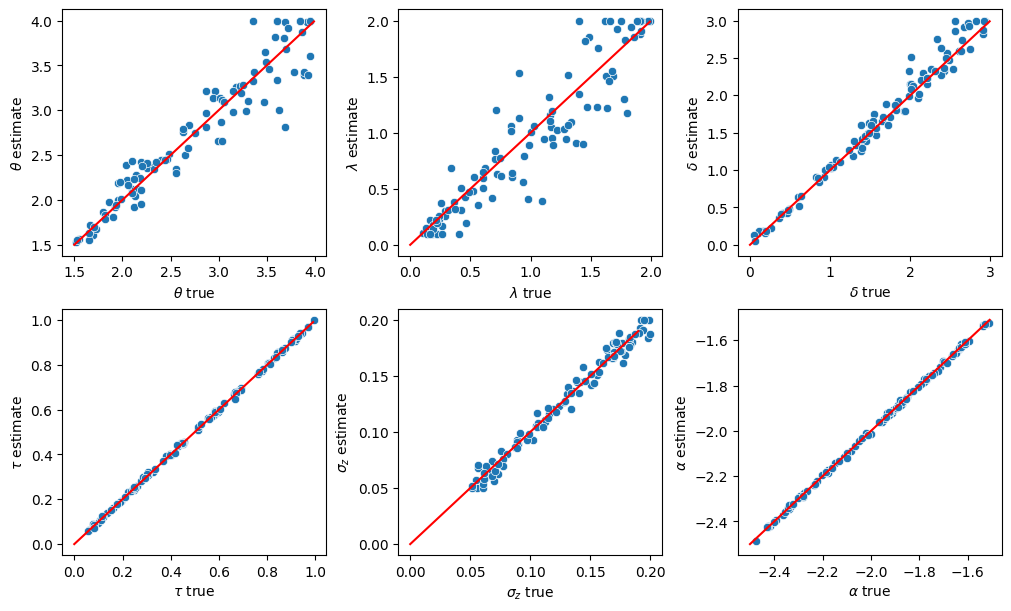

In [8]:
plt.figure(figsize=(10, 6), layout='constrained')

plt.subplot(231)
plt.plot(np.arange(1.5, 4, 0.01), np.arange(1.5, 4, 0.01), c='red')
sns.scatterplot(x='a_true', y='a_estimate', data=recovery_df);
plt.xlabel(r'$\theta$ true')
plt.ylabel(r'$\theta$ estimate')

plt.subplot(232)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='lambda_true', y='lambda_estimate', data=recovery_df);
plt.xlabel(r'$\lambda$ true')
plt.ylabel(r'$\lambda$ estimate')

plt.subplot(233)
plt.plot(np.arange(0, 3, 0.01), np.arange(0, 3, 0.01), c='red')
sns.scatterplot(x='delta_true', y='delta_estimate', data=recovery_df);
plt.xlabel(r'$\delta$ true')
plt.ylabel(r'$\delta$ estimate')

plt.subplot(234)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df);
plt.xlabel(r'$\tau$ true')
plt.ylabel(r'$\tau$ estimate')

plt.subplot(235)
plt.plot(np.arange(0, 0.2, 0.01), np.arange(0, .2, 0.01), c='red')
sns.scatterplot(x='sigma_z_true', y='sigma_z_estimate', data=recovery_df);
plt.xlabel(r'$\sigma_z$ true')
plt.ylabel(r'$\sigma_z$ estimate');

plt.subplot(236)
plt.plot(np.arange(-2.5, -1.5, 0.01), np.arange(-2.5, -1.5, 0.01), c='red')
sns.scatterplot(x='alpha_true', y='alpha_estimate', data=recovery_df);
plt.xlabel(r'$\alpha$ true')
plt.ylabel(r'$\alpha$ estimate');

In [9]:
print(recovery_df.shape)
recovery_df.corr()

(100, 14)


,a_true,a_estimate,lambda_true,lambda_estimate,delta_true,delta_estimate,sigma_z_true,sigma_z_estimate,ndt_true,ndt_estimate,alpha_true,alpha_estimate,sigma_a_true,sigma_a_estimate
a_true,1.000000,0.954036,0.174140,0.068669,0.016433,0.036865,-0.064616,-0.091300,-0.026855,-0.026197,0.145102,0.141089,-0.064616,-0.066430
a_estimate,0.954036,1.000000,0.143777,0.138311,0.056635,0.062861,-0.074427,-0.095949,0.031951,0.031430,0.161453,0.158590,-0.074427,-0.056751
lambda_true,0.174140,0.143777,1.000000,0.924907,0.013480,-0.002381,0.029208,0.000313,-0.010739,-0.008751,0.003000,0.001721,0.029208,-0.012043
lambda_estimate,0.068669,0.138311,0.924907,1.000000,0.057936,0.010371,0.024003,0.008753,0.039785,0.040607,0.026922,0.027179,0.024003,0.009953
delta_true,0.016433,0.056635,0.013480,0.057936,1.000000,0.989551,-0.069439,-0.062506,0.220918,0.219496,0.010700,0.008396,-0.069439,0.073609
delta_estimate,0.036865,0.062861,-0.002381,0.010371,0.989551,1.000000,-0.072089,-0.068342,0.218460,0.216998,0.007467,0.004498,-0.072089,0.056691
sigma_z_true,-0.064616,-0.074427,0.029208,0.024003,-0.069439,-0.072089,1.000000,0.990377,0.128535,0.130876,-0.090234,-0.092227,1.000000,-0.131170
sigma_z_estimate,-0.091300,-0.095949,0.000313,0.008753,-0.062506,-0.068342,0.990377,1.000000,0.119816,0.122228,-0.078651,-0.080541,0.990377,-0.127732
ndt_true,-0.026855,0.031951,-0.010739,0.039785,0.220918,0.218460,0.128535,0.119816,1.000000,0.999773,-0.051031,-0.048903,0.128535,-0.033407
ndt_estimate,-0.026197,0.031430,-0.008751,0.040607,0.219496,0.216998,0.130876,0.122228,0.999773,1.000000,-0.050592,-0.048538,0.130876,-0.030489


In [10]:
recovery_df.to_csv('Hyperbolic_rec.csv')